In [1]:
import torch
from torch import nn
import math
from d2l import torch as d2l

In [2]:
def masked_softmax(X,valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_lens.dim()==1:
            valid_lens=torch.repeat_interleave(valid_lens,shape[1])
        else:
            valid_lens=valid_lens.reshape(-1)
        X=d2l.sequence_mask(
            X.reshape(-1,shape[-1]),valid_lens,value=-1e6
        )
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
masked_softmax(torch.rand(2,2,4),torch.tensor([2,3]))

tensor([[[0.3392, 0.6608, 0.0000, 0.0000],
         [0.3533, 0.6467, 0.0000, 0.0000]],

        [[0.2887, 0.2485, 0.4628, 0.0000],
         [0.4332, 0.2900, 0.2768, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2,2,4),torch.tensor([[1,3],[2,4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4115, 0.2001, 0.3883, 0.0000]],

        [[0.7058, 0.2942, 0.0000, 0.0000],
         [0.2338, 0.2908, 0.1661, 0.3094]]])

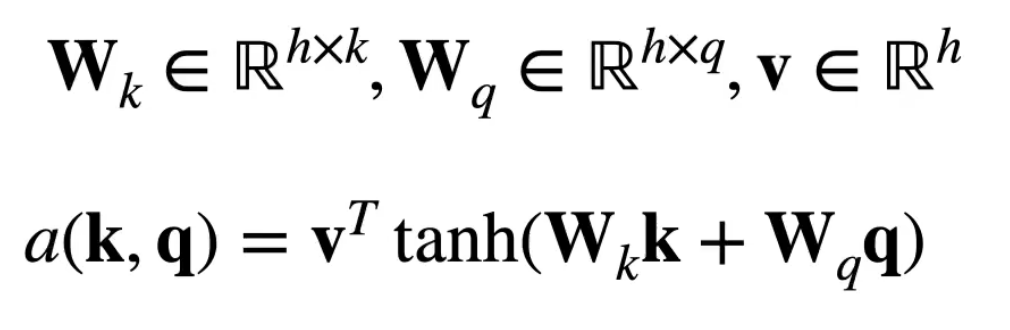

In [5]:
class AdditiveAttention(nn.Module):
    def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
        super(AdditiveAttention,self).__init__(**kwargs)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=False)
        self.W_q=nn.Linear(query_size,num_hiddens,bias=False)
        self.W_v=nn.Linear(num_hiddens,1,bias=False)
        self.dropout=nn.Dropout(dropout)
    def forward(self,queries,keys,values,valid_lens):#valid_lens是考虑要多少个 key\value pair
        queries,keys=self.W_q(queries),self.W_k(keys)
        features=queries.unsqueeze(2)+keys.unsqueeze(1)#batches,query_size,key_size,h
        features=torch.tanh(features)
        scores=self.W_v(features).squeeze(-1)
        # scores的形状：(batch_size，查询的个数n，“键-值”对的个数m)
        self.attention_weights=masked_softmax(scores,valid_lens)
        # values的形状：(batch_size，“键－值”对的个数m，值的维度v)
        return torch.bmm(self.dropout(self.attention_weights),values)#queries,values

In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10,
                                                       4).repeat(2, 1, 1)
# query(batch_size,查询个数，query的长度)(2, 1, 2)
# keys(batch_size,键值对个数，key的长度)(2, 10, 2)
# values(batch_size, 键值对个数, value的长度)(2, 10, 4)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

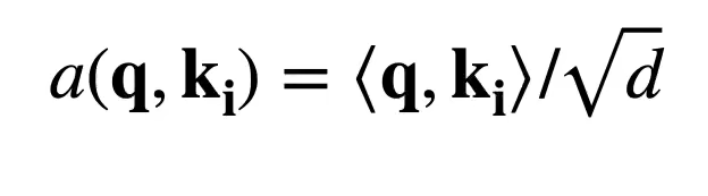

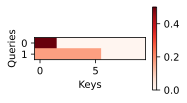

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [8]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        # queries的形状：(batch_size，查询的个数，d)
        # keys的形状：(batch_size，“键－值”对的个数，d)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

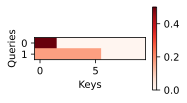

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')